# Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn. metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/content/TSLA.CSV')
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-05-21,39.551998,41.480000,39.208000,41.015999,90019500,0,0.0
1,2019-05-22,39.820000,40.787998,38.355999,38.546001,93426000,0,0.0
2,2019-05-23,38.868000,39.894001,37.243999,39.098000,132735500,0,0.0
3,2019-05-24,39.966000,39.995998,37.750000,38.125999,70683000,0,0.0
4,2019-05-28,38.240002,39.000000,37.570000,37.740002,51564500,0,0.0


In [5]:
stock_data = data[['Date','Close']]

stock_data.head(7)

,Date,Close
0,2019-05-21,41.015999
1,2019-05-22,38.546001
2,2019-05-23,39.098000
3,2019-05-24,38.125999
4,2019-05-28,37.740002
5,2019-05-29,37.972000
6,2019-05-30,37.644001


In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    758 non-null    object 
 1   Close   758 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [7]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    758 non-null    datetime64[ns]
 1   Close   758 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [8]:
stock_data.head(2)

,Date,Close
0,2019-05-21,41.015999
1,2019-05-22,38.546001


In [9]:
stock_data = stock_data.set_index('Date')
stock_data.head(2)

,Close
Date,
2019-05-21,41.015999
2019-05-22,38.546001


# EDA

In [10]:
stock_data.describe()

,Close
count,758.000000
mean,485.531513
std,353.160353
min,35.793999
25%,112.323500
50%,488.125000
75%,762.142502
max,1229.910034


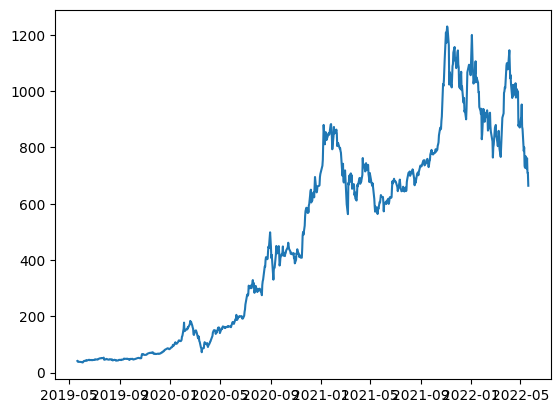

In [11]:
plt.plot(stock_data.Close)

(array([228.,  57.,  38.,  59.,  50., 127.,  81.,  44.,  59.,  15.]),
 array([  35.79399872,  155.20560226,  274.61720581,  394.02880936,
         513.4404129 ,  632.85201645,  752.26362   ,  871.67522354,
         991.08682709, 1110.49843063, 1229.91003418]),
 <BarContainer object of 10 artists>)

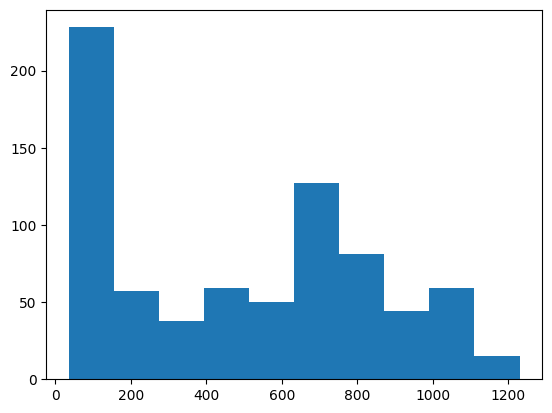

In [12]:
plt.hist(stock_data.Close)

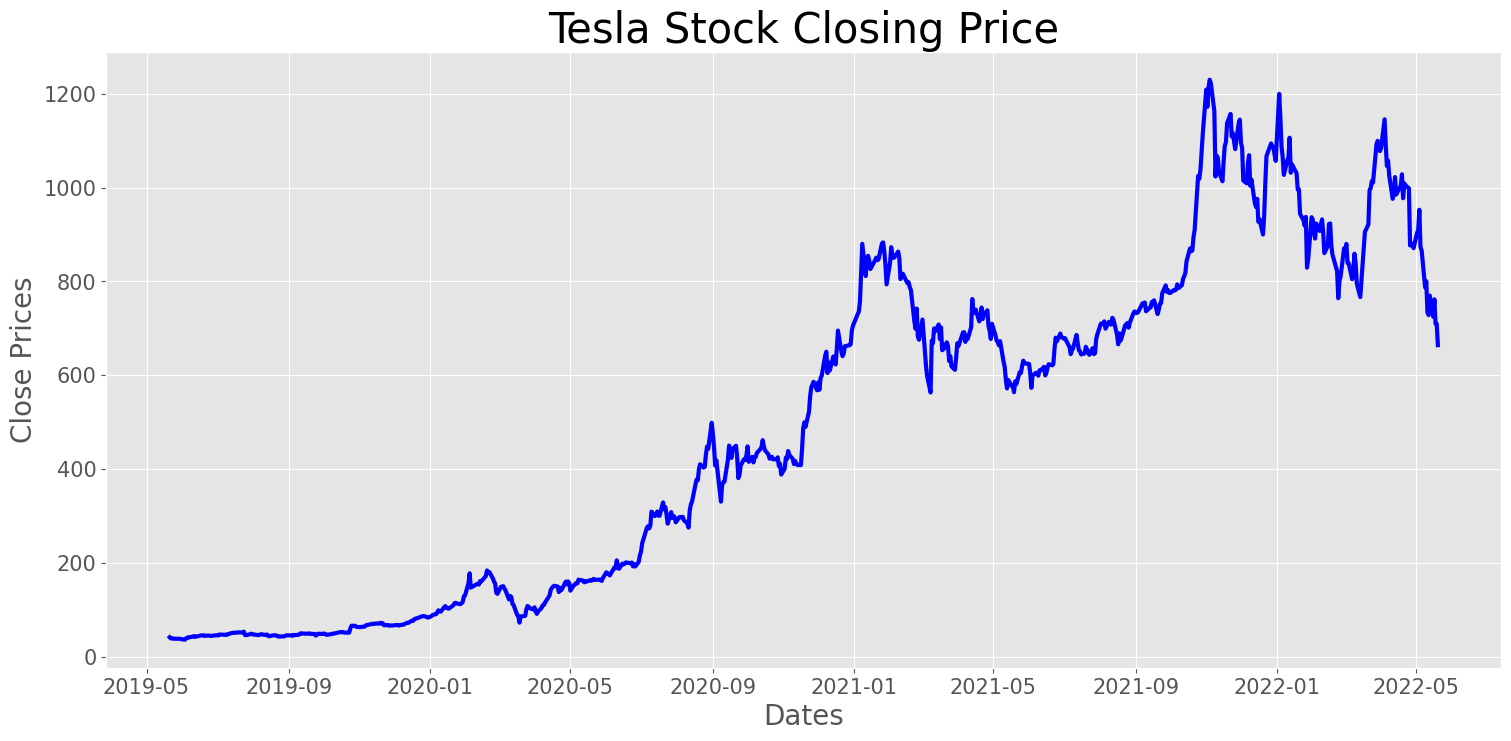

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.plot(stock_data.Close, linewidth = 3, color = 'blue')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

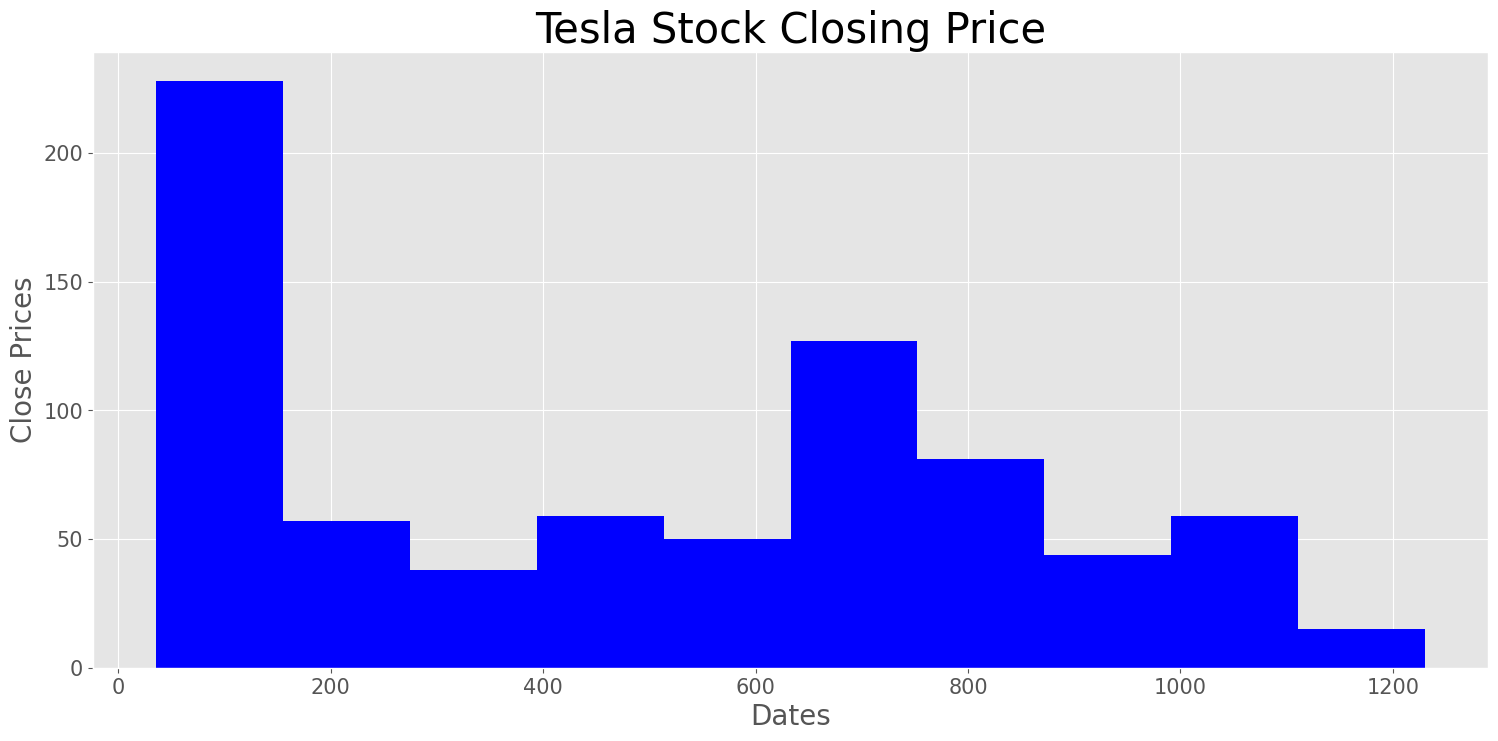

In [14]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.hist(stock_data.Close, linewidth = 3, color = 'blue')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

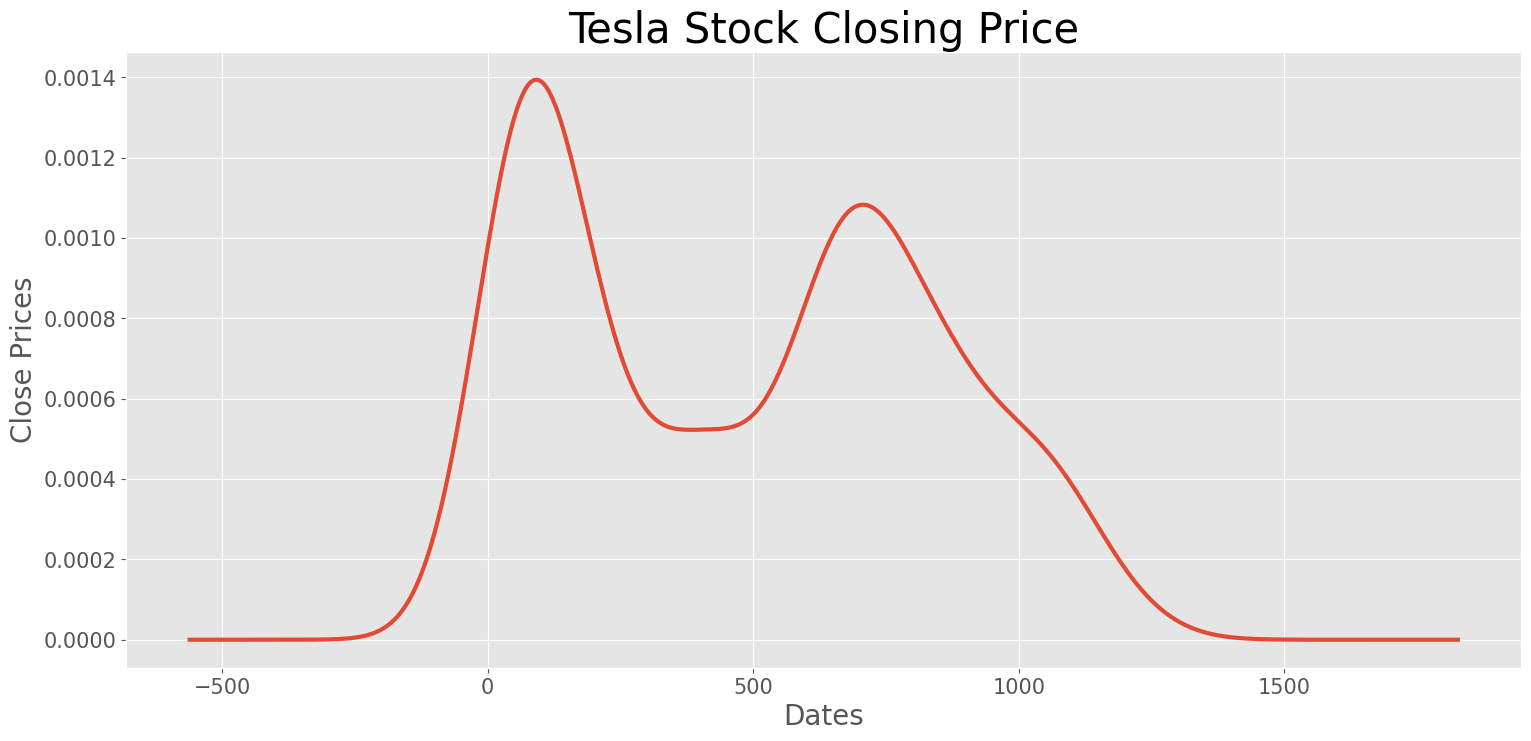

In [15]:
df_close = stock_data.Close

df_close.plot(kind = 'kde', figsize = (18,8), linewidth = 3)

plt.grid('both')
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

In [16]:
roll_mean = stock_data.Close.rolling(48).mean()

In [18]:
roll_std = stock_data.Close.rolling(48).std()

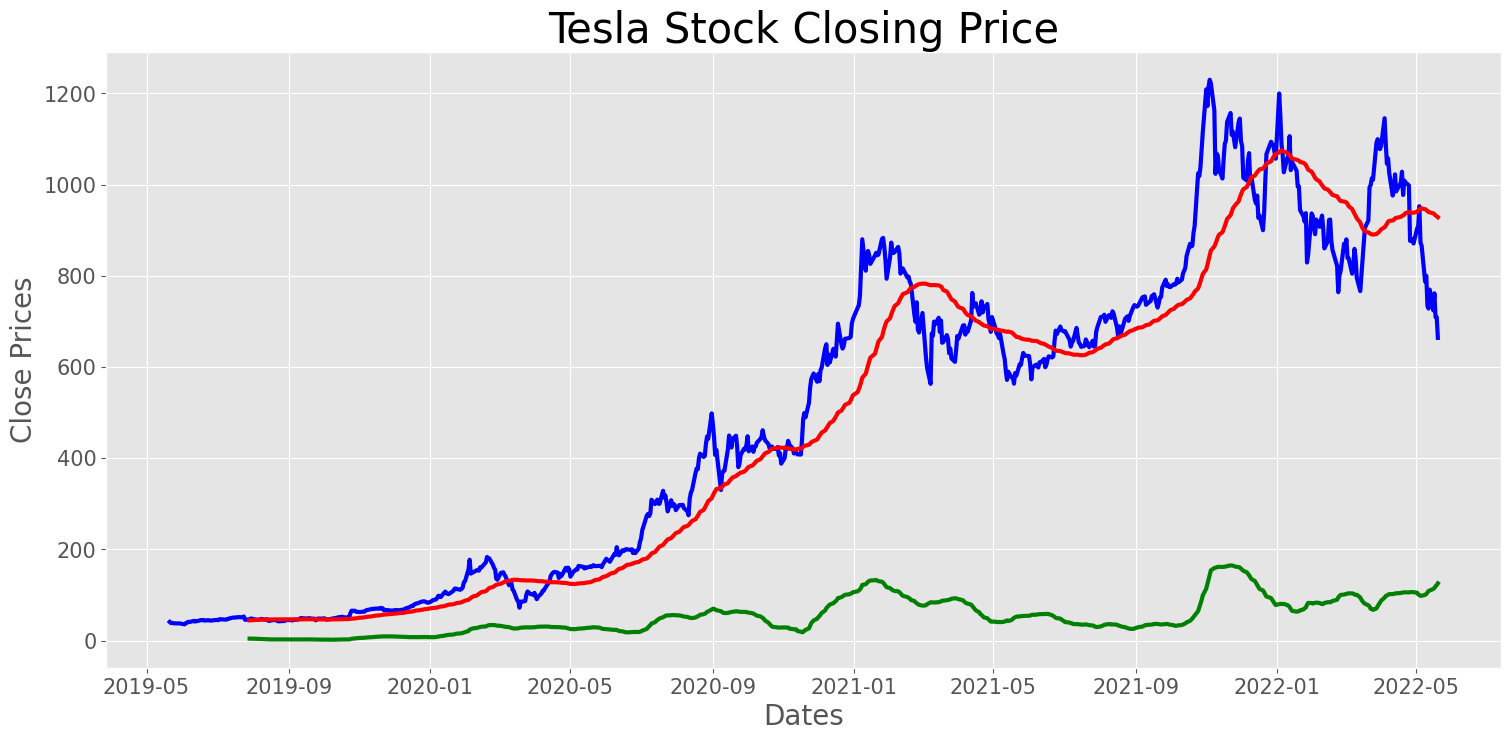

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)
plt.plot(stock_data.Close, linewidth = 3, color = 'blue')
plt.plot(roll_mean, linewidth = 3, color = 'red')
plt.plot(roll_std, linewidth = 3, color = 'green')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

In [20]:
# ADF (Ada Fuller Test)

from statsmodels.tsa.stattools import adfuller
adft = adfuller(stock_data['Close'])
adft

(-1.3630085817037492,
 0.5998762543050696,
 9,
 748,
 {'1%': -3.43912257105195,
  '5%': -2.8654117005229844,
  '10%': -2.568831705010152},
 6794.359259220987)

In [21]:
pd.Series(adft[0:4], index = ['test stats', 'p-value', 'lag', 'data points'])

test stats      -1.363009
p-value          0.599876
lag              9.000000
data points    748.000000
dtype: float64

In [38]:
# Test for stationary


def test_stationarity(timeseries):
    # determining Rolling statistics
    roll_mean = timeseries.rolling(48).mean()
    roll_std = timeseries.rolling(48).std()
    #plot Rolling statistics
    plt.figure(figsize=(18,8))
    plt.grid('both')
    plt.xlabel('Dates', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.ylabel('Close Prices', fontsize = 20)
    plt.yticks(fontsize = 15)

    plt.plot(timeseries, linewidth = 2, color = 'blue', label='Original')
    plt.plot(roll_mean, linewidth = 2, color = 'red', label='Rolling Mean')
    plt.plot(roll_std, linewidth = 2, color = 'black',  label='Rolling Std')

    plt.legend(loc='best', fontsize=20, shadow=True, facecolor='lightpink', edgecolor = 'k')

    plt.title('Rolling Mean and Standard Deviation', fontsize = 30)
    plt.show(block=False)


    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index = ['test stats', 'p-value', 'lag', 'data points'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)


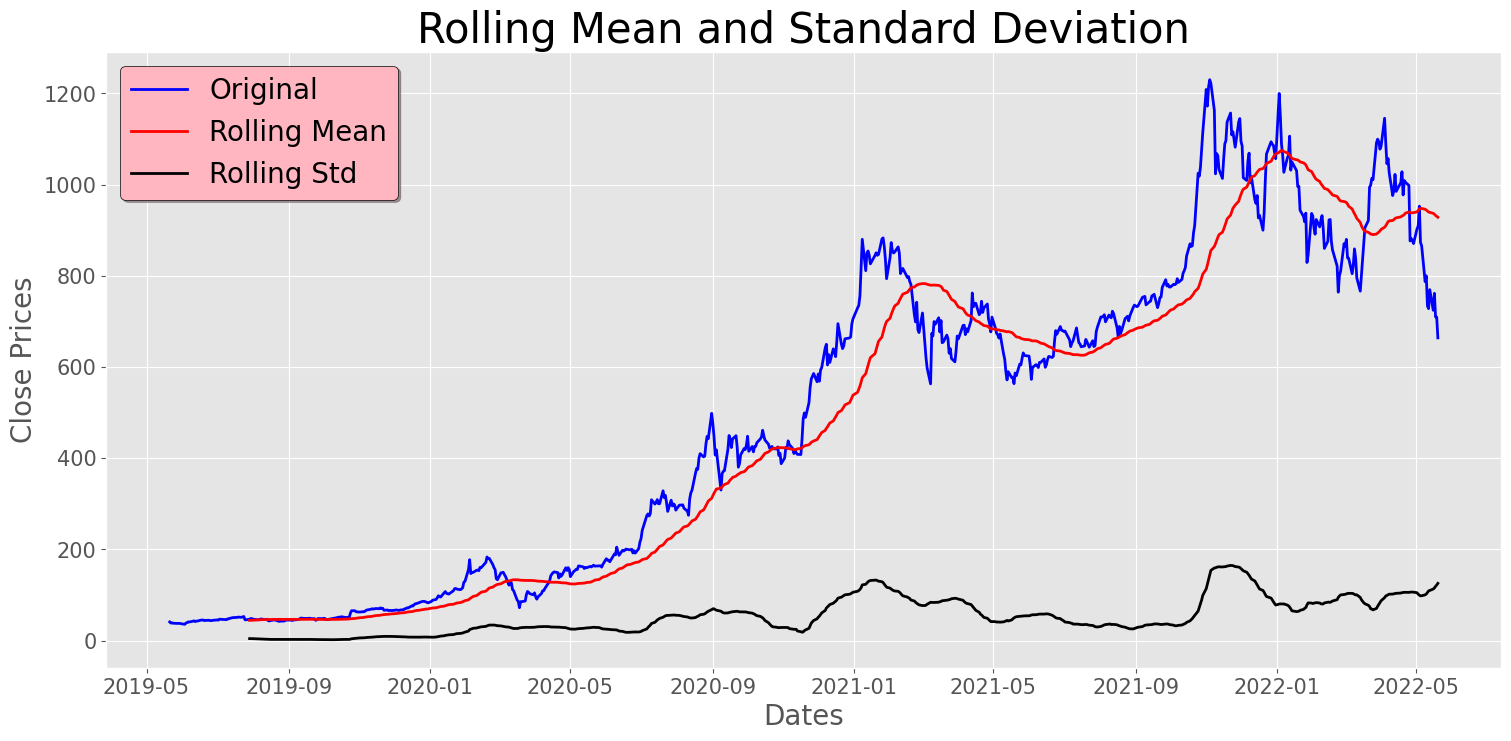

Results of dickey fuller test
test stats               -1.363009
p-value                   0.599876
lag                       9.000000
data points             748.000000
critical value (1%)      -3.439123
critical value (5%)      -2.865412
critical value (10%)     -2.568832
dtype: float64


In [39]:
test_stationarity(stock_data.Close)

# DATA DECOMPOSITION

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(stock_data.Close, period=12)
result.seasonal

Date
2019-05-21   -2.346452
2019-05-22    3.768884
2019-05-23   -0.777006
2019-05-24   -0.654226
2019-05-28   -2.737845
                ...   
2022-05-16    2.149519
2022-05-17    1.323680
2022-05-18    1.837638
2022-05-19   -2.346452
2022-05-20    3.768884
Name: seasonal, Length: 758, dtype: float64

<Figure size 2000x1000 with 0 Axes>

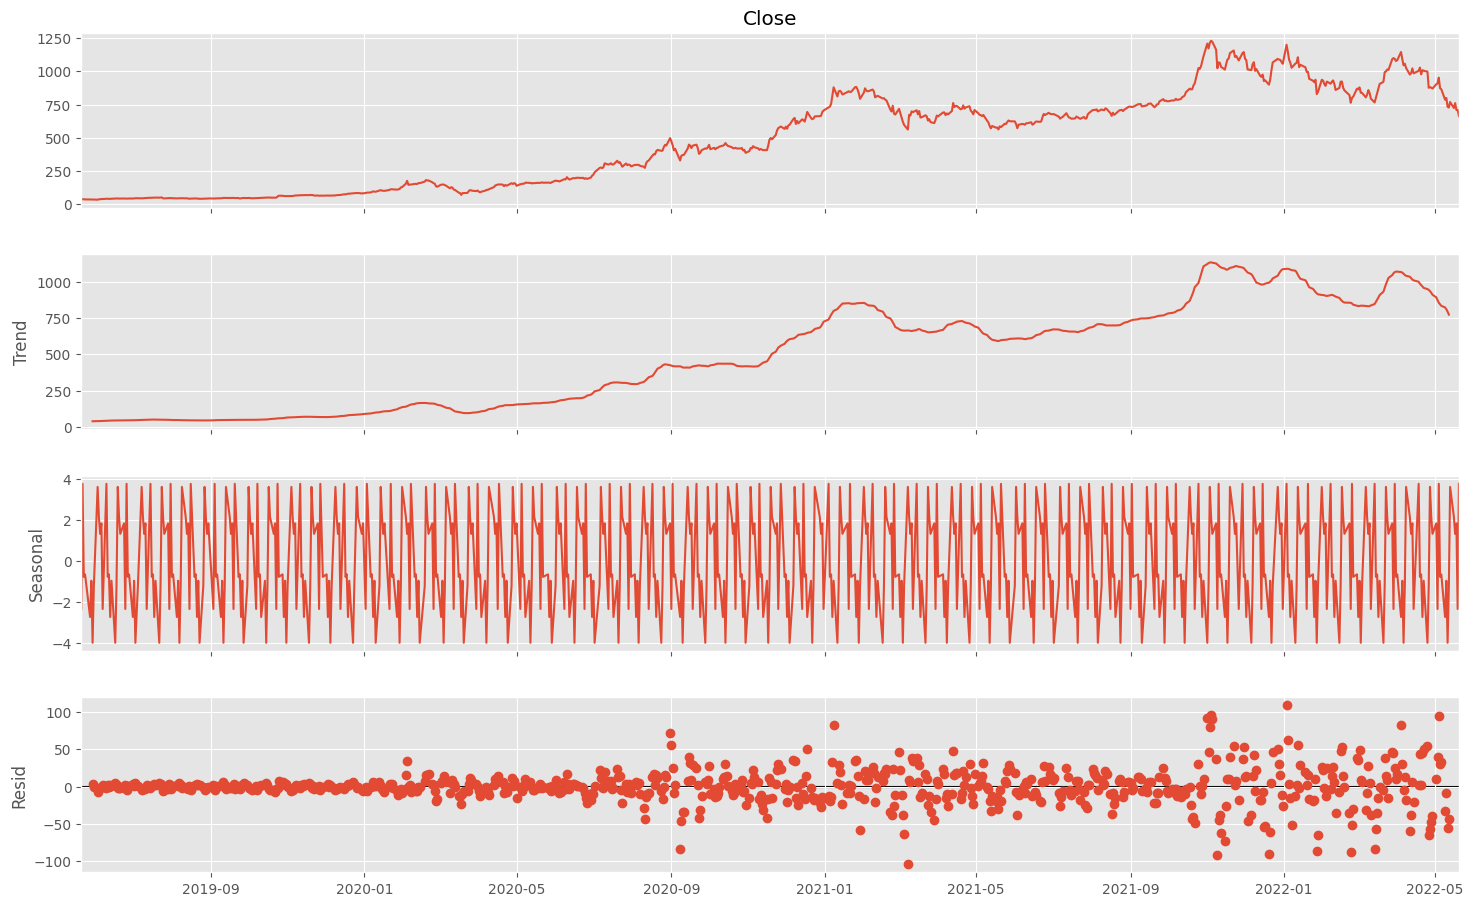

In [41]:
fig = plt.figure(figsize=(20,10))
fig = result.plot()
fig.set_size_inches(17,10)

In [42]:
result = seasonal_decompose(stock_data.Close, period=12, model = 'multiplicative')

<Figure size 2000x1000 with 0 Axes>

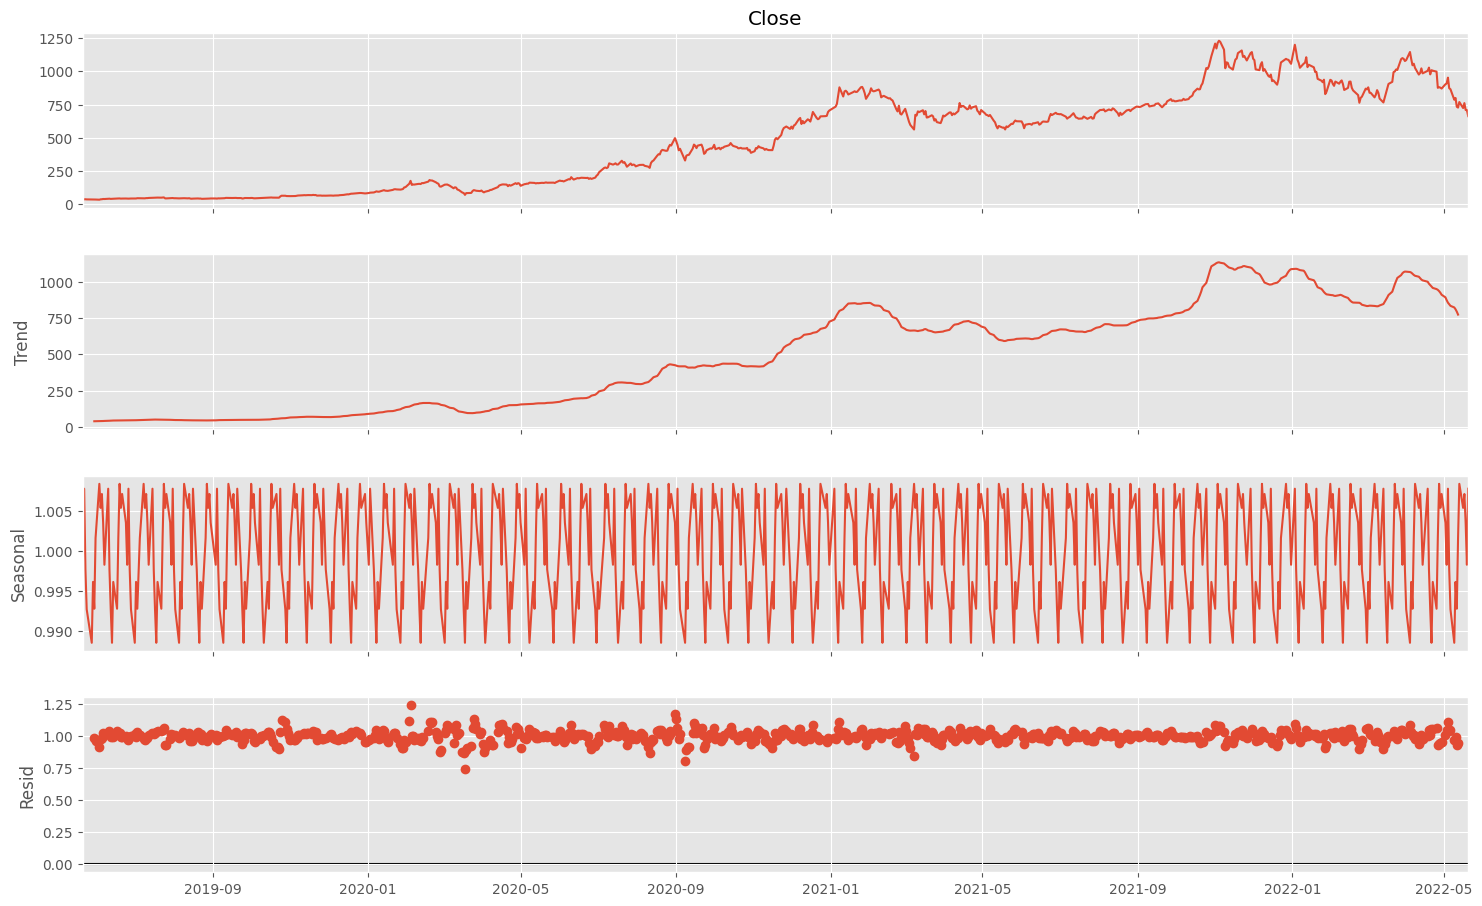

In [43]:
fig = plt.figure(figsize=(20,10))
fig = result.plot()
fig.set_size_inches(17,10)

# Check Outliers

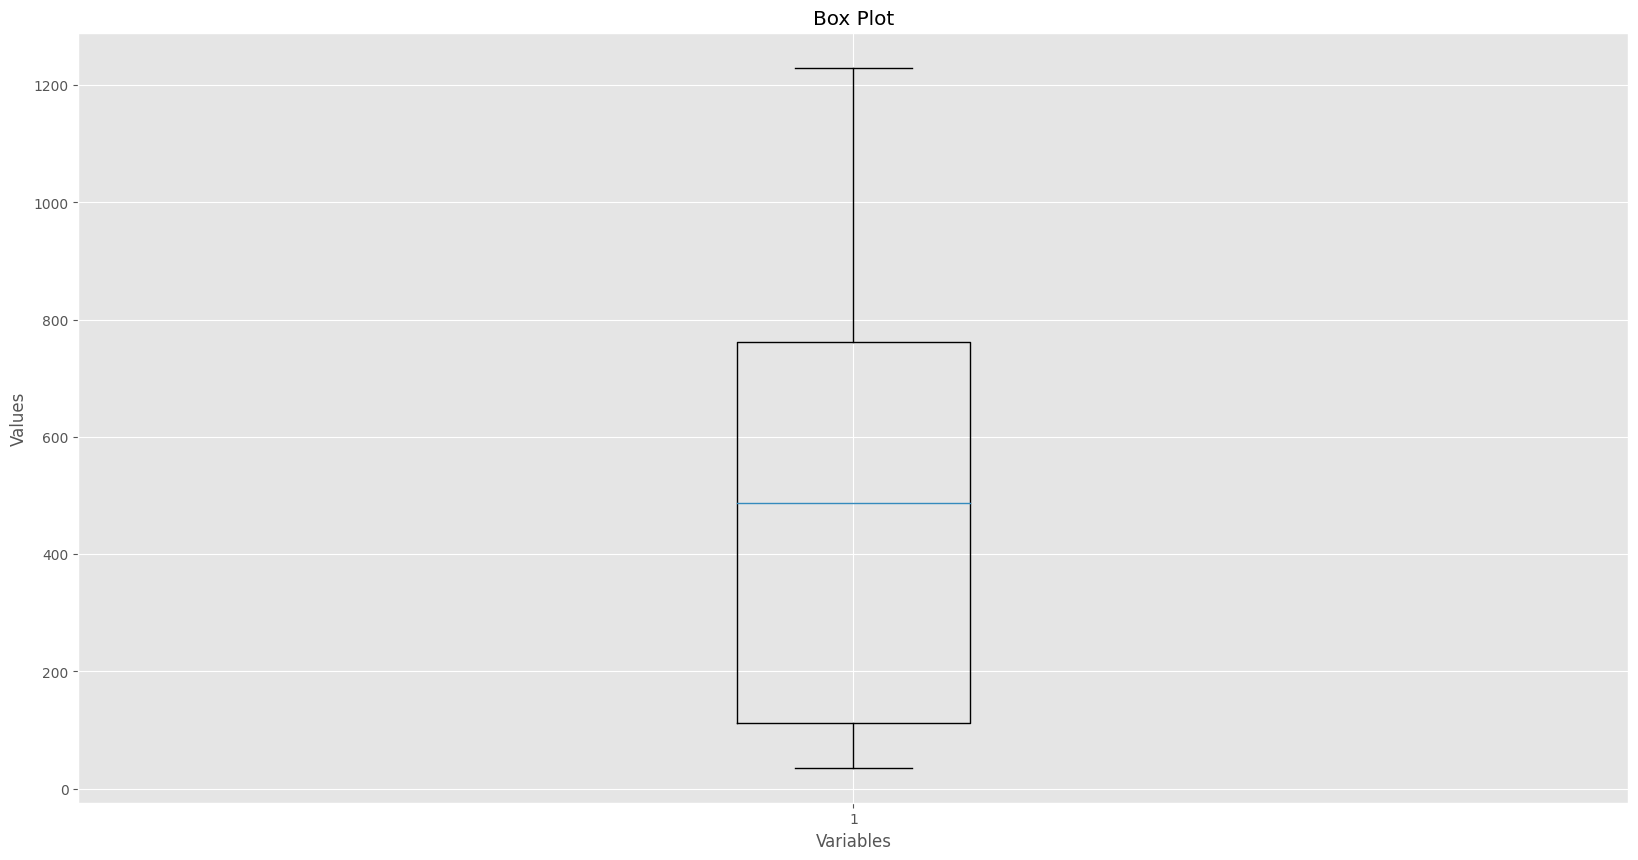

In [44]:
fig, ax = plt.subplots(figsize=(20,10))


ax.boxplot(stock_data.Close)

ax.set_xlabel('Variables')

ax.set_ylabel('Values')

ax.set_title('Box Plot')

plt.show()

# Check Auto Correlation

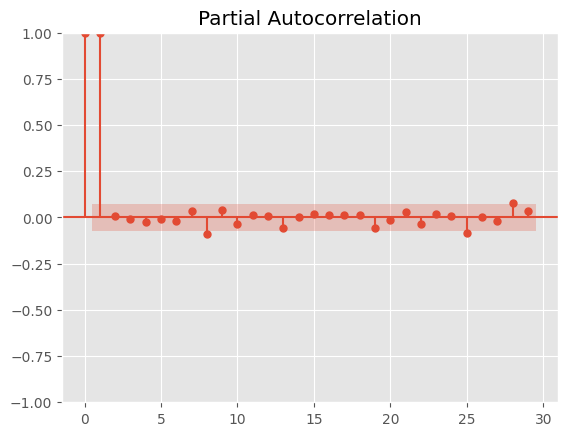

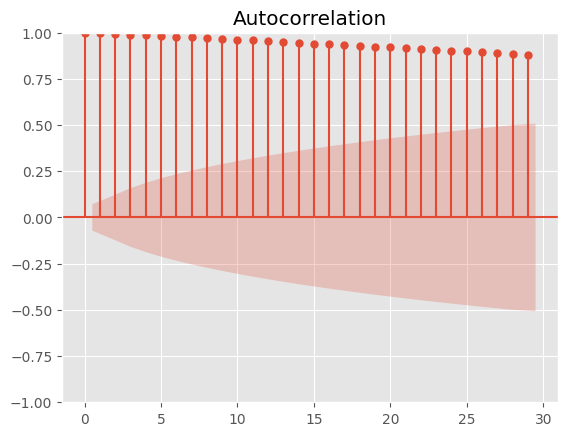

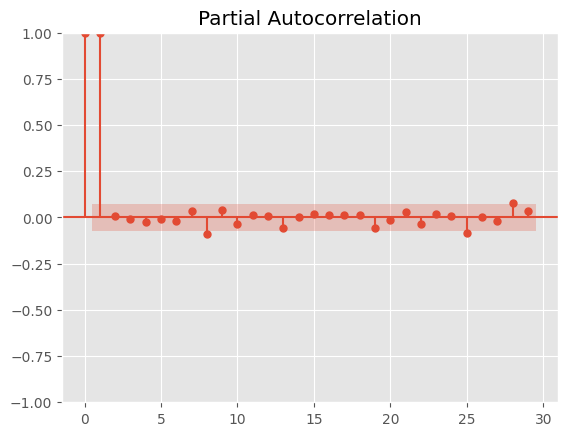

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(stock_data.Close)
plot_pacf(stock_data.Close)

# Preprocessing of the data

##### Convert data into stationary time series

In [46]:
# differencing

df_close = stock_data['Close']
df_close = df_close.diff(1)
df_close

Date
2019-05-21          NaN
2019-05-22    -2.469997
2019-05-23     0.551998
2019-05-24    -0.972000
2019-05-28    -0.385998
                ...    
2022-05-16   -45.220032
2022-05-17    37.239990
2022-05-18   -51.799988
2022-05-19    -0.390015
2022-05-20   -45.519958
Name: Close, Length: 758, dtype: float64

In [47]:
df_close = df_close.dropna()
df_close

Date
2019-05-22    -2.469997
2019-05-23     0.551998
2019-05-24    -0.972000
2019-05-28    -0.385998
2019-05-29     0.231998
                ...    
2022-05-16   -45.220032
2022-05-17    37.239990
2022-05-18   -51.799988
2022-05-19    -0.390015
2022-05-20   -45.519958
Name: Close, Length: 757, dtype: float64

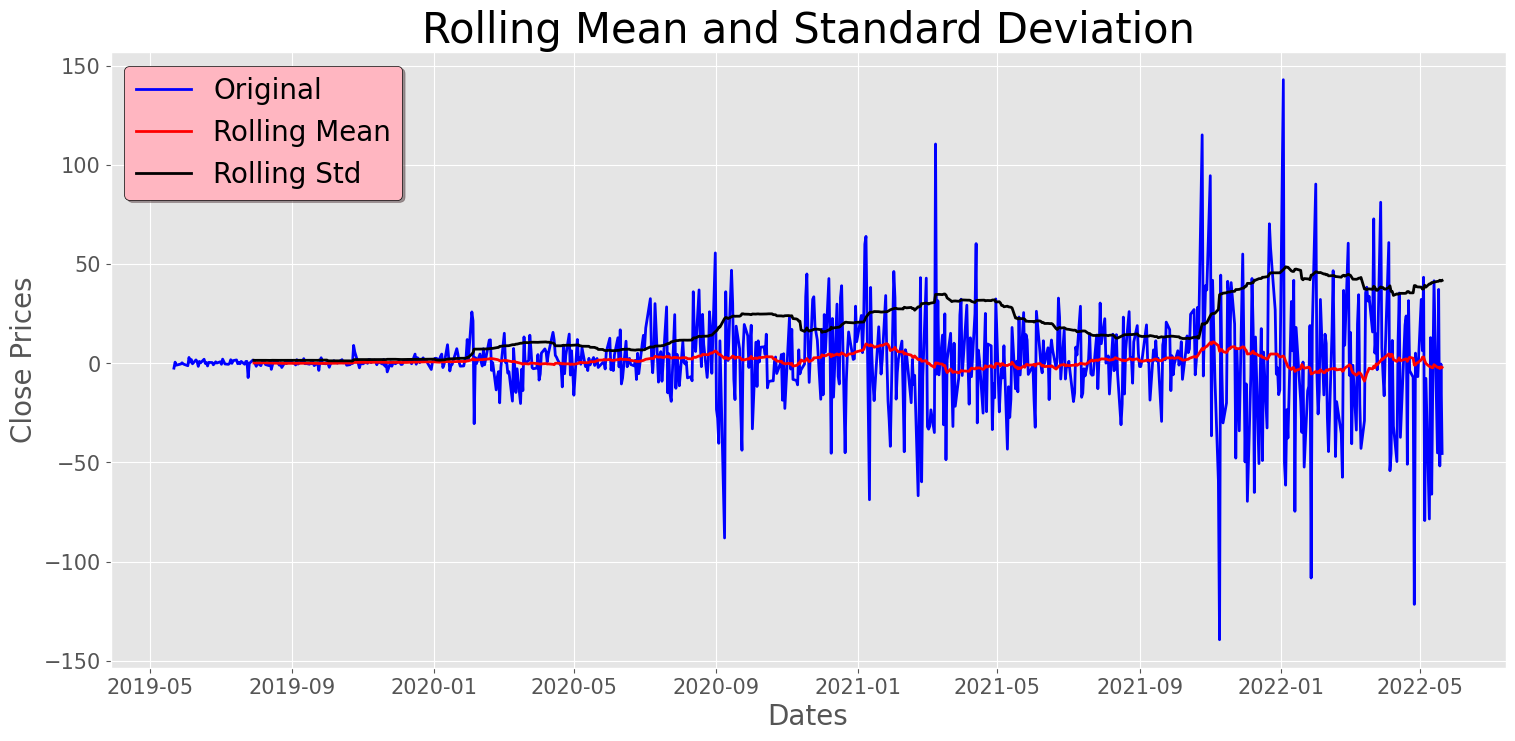

Results of dickey fuller test
test stats             -8.324564e+00
p-value                 3.498786e-13
lag                     8.000000e+00
data points             7.480000e+02
critical value (1%)    -3.439123e+00
critical value (5%)    -2.865412e+00
critical value (10%)   -2.568832e+00
dtype: float64


In [48]:
test_stationarity(df_close)

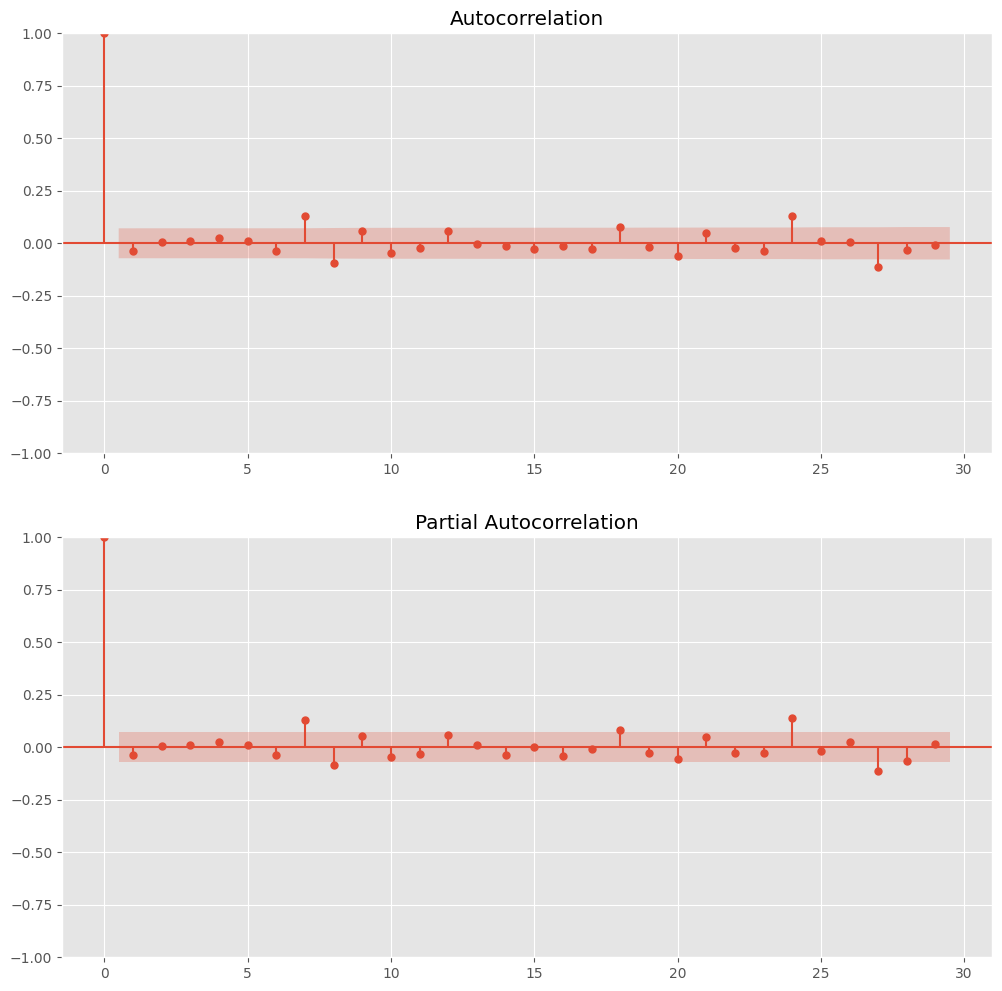

In [49]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_close, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_close, ax=ax2)

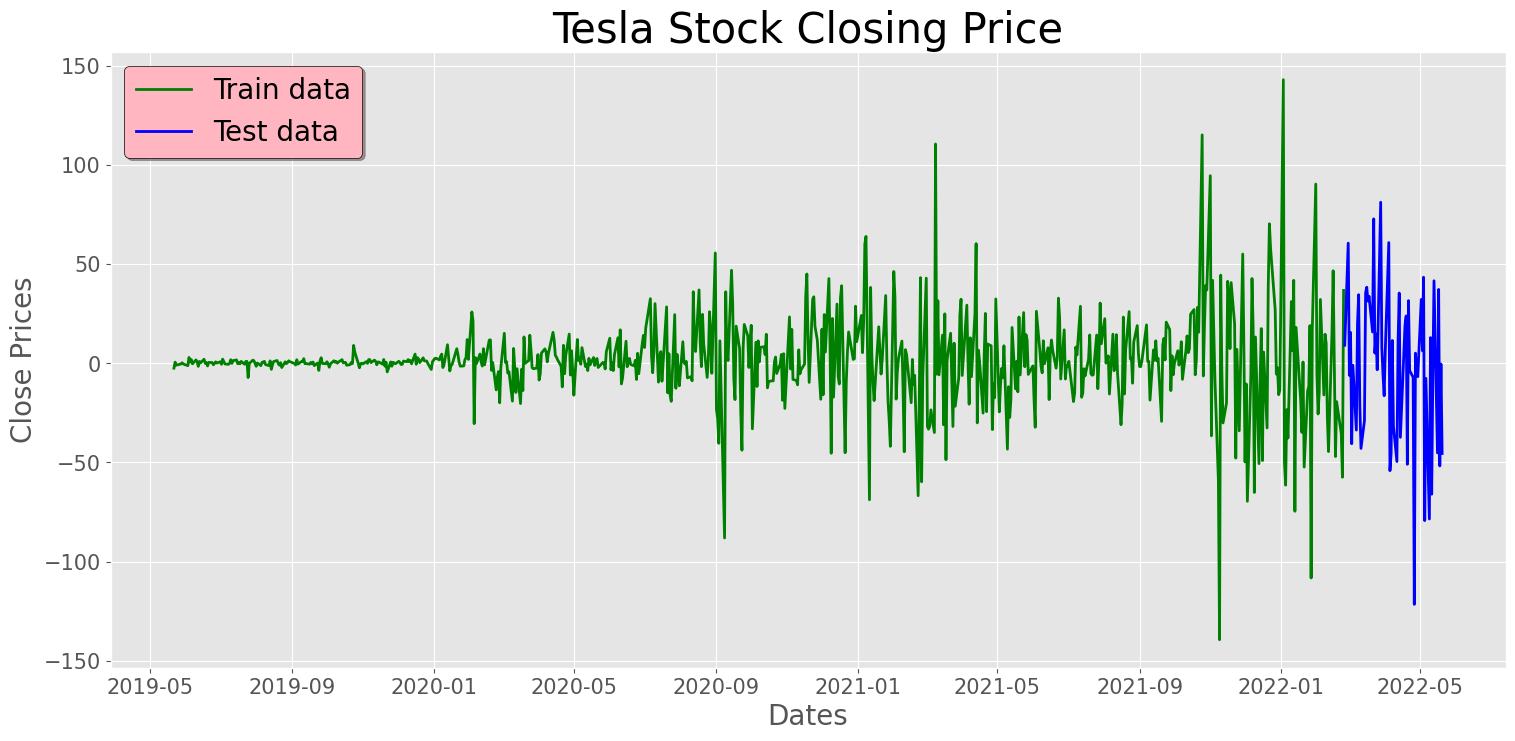

In [50]:
# split data into train test split

train_data = df_close[0:-60]
test_data = df_close[-60:]

plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15)

plt.plot(train_data, linewidth = 2, color = 'green', label = 'Train data')

plt.plot(test_data, linewidth = 2, color = 'blue', label = 'Test data')

plt.legend(fontsize = 20, shadow = True, facecolor='lightpink', edgecolor = 'k')

plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

# Model Building

In [51]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn. metrics import mean_squared_error

In [52]:
history = [x for x in train_data]

In [53]:
model = ARIMA(history, order=(1,1,1))
model

In [54]:
model = model.fit()

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  697
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3148.870
Date:                Thu, 14 Mar 2024   AIC                           6303.741
Time:                        16:35:27   BIC                           6317.377
Sample:                             0   HQIC                          6309.013
                                - 697                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0285      0.025     -1.150      0.250      -0.077       0.020
ma.L1         -0.9991      0.012    -81.341      0.000      -1.023      -0.975
sigma2       493.6006     12.978     38.035      0.000     468.165     519.036
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2092.37
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              31.85   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
model.forecast()

array([0.04741687])

In [57]:
test_data[0]

9.0999755859375

In [58]:
mean_squared_error([test_data[0]], model.forecast())

81.94881931903844

In [59]:
import numpy as np
np.sqrt(mean_squared_error([test_data[0]], model.forecast()))

9.052558716685489

In [60]:
p_values = range(0,3)

d_values = range(0,3)

q_values = range(0,3)

In [61]:
for i in p_values:
    for j in d_values:
        for k in q_values:
            print(i,j,k)

0 0 0
0 0 1
0 0 2
0 1 0
0 1 1
0 1 2
0 2 0
0 2 1
0 2 2
1 0 0
1 0 1
1 0 2
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 2 2
2 0 0
2 0 1
2 0 2
2 1 0
2 1 1
2 1 2
2 2 0
2 2 1
2 2 2


In [62]:
def train_arima_model(X, y, arima_order):
    # prepare training dataset
    # make prediction list
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)
        history.append(y[t])

    # calculate out of sample error

    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [63]:
def evaluate_models(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = train_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [64]:
import warnings
warnings.filterwarnings('ignore')

p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)


evaluate_models(train_data, test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=39.610
ARIMA(0, 0, 1) RMSE=39.578
ARIMA(0, 0, 2) RMSE=39.728
ARIMA(0, 1, 0) RMSE=57.835
ARIMA(0, 1, 1) RMSE=39.611
ARIMA(0, 1, 2) RMSE=39.580
ARIMA(0, 2, 0) RMSE=104.683
ARIMA(0, 2, 1) RMSE=57.876
ARIMA(0, 2, 2) RMSE=39.615
ARIMA(1, 0, 0) RMSE=39.570
ARIMA(1, 0, 1) RMSE=39.636
ARIMA(1, 0, 2) RMSE=40.047
ARIMA(1, 1, 0) RMSE=46.184
ARIMA(1, 1, 1) RMSE=39.573
ARIMA(1, 1, 2) RMSE=39.731
ARIMA(1, 2, 0) RMSE=68.740
ARIMA(1, 2, 1) RMSE=46.221
ARIMA(1, 2, 2) RMSE=39.529
ARIMA(2, 0, 0) RMSE=39.746
ARIMA(2, 0, 1) RMSE=39.884
ARIMA(2, 0, 2) RMSE=40.100
ARIMA(2, 1, 0) RMSE=45.781
ARIMA(2, 1, 1) RMSE=39.738
ARIMA(2, 1, 2) RMSE=39.732
ARIMA(2, 2, 0) RMSE=63.008
ARIMA(2, 2, 1) RMSE=45.809
Best ARIMA(1, 2, 2) RMSE=39.529


In [75]:
history = [x for x in train_data]

predictions = list()

for i  in range(len(test_data)):
    model = ARIMA(history, order=(2,0,0))
    model = model.fit()
    fc = model.forecast(alpha = 0.05)
    predictions.append(fc)
    history.append(test_data[i])
print(f"RMSE is {np.sqrt(mean_squared_error(test_data,predictions))}")

RMSE is 39.74611724745828


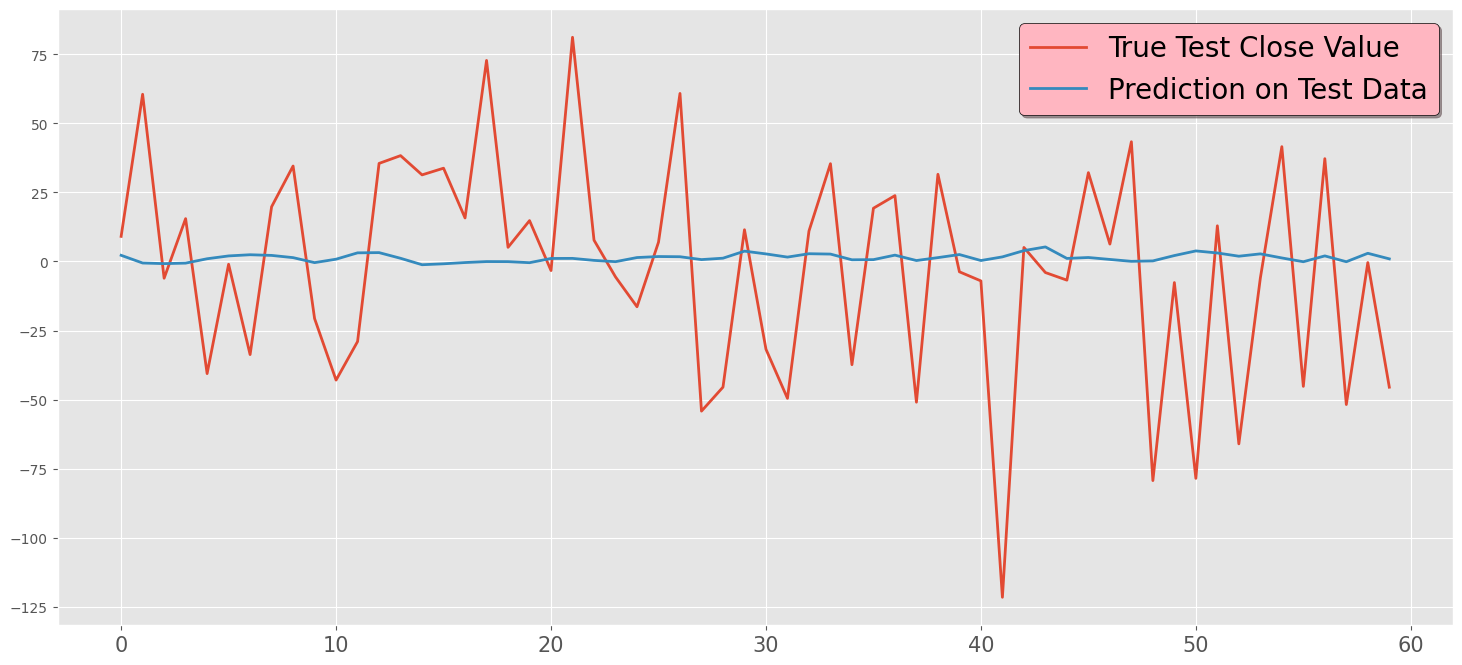

In [76]:
plt.figure(figsize=(18,8))
plt.grid(True)

plt.plot(range(len(test_data)), test_data, label= 'True Test Close Value', linewidth = 2)
plt.plot(range(len(predictions)), predictions, label= 'Prediction on Test Data', linewidth = 2)


plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.legend(fontsize = 20, shadow = True, facecolor='lightpink', edgecolor = 'k')
plt.show()

In [77]:
fc_series = pd.Series(predictions, index=test_data.index)
fc_series

Date
2022-02-25         [2.24100046560046]
2022-02-28      [-0.5487419521953845]
2022-03-01      [-0.7707957790290791]
2022-03-02      [-0.5895914689661128]
2022-03-03       [0.9932868327636508]
2022-03-04        [2.019638851455633]
2022-03-07        [2.447436916264773]
2022-03-08        [2.205756672144112]
2022-03-09       [1.4000667381317453]
2022-03-10      [-0.4097352615645695]
2022-03-11       [0.8351531026556664]
2022-03-14         [3.13547931408288]
2022-03-15       [3.2160350236076125]
2022-03-16       [1.1606981633934588]
2022-03-17      [-1.1695134195571562]
2022-03-18      [-0.8330429814800633]
2022-03-21      [-0.3794510394507331]
2022-03-22    [-0.027500738081433607]
2022-03-23     [-0.04912688353942074]
2022-03-24     [-0.43141678219506785]
2022-03-25       [1.0997791939878878]
2022-03-28       [1.1284023899350573]
2022-03-29       [0.4035279015880189]
2022-03-30     [-0.06476466709132733]
2022-03-31       [1.4294700234922901]
2022-04-01       [1.7980380118102013]
2022-04

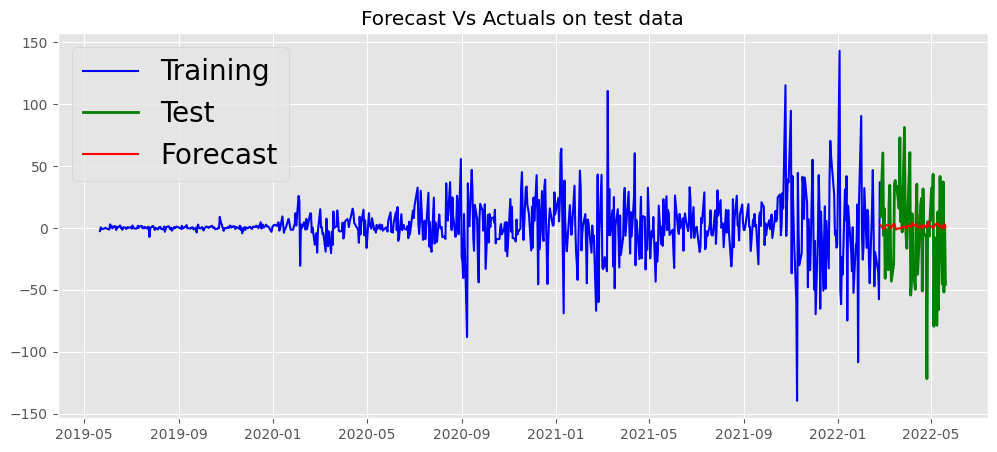

In [78]:
plt.figure(figsize=(12,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label= 'Training', color='blue')
plt.plot(test_data, label= 'Test', color='green', linewidth = 2)
plt.plot(fc_series, label= 'Forecast', color='red')

plt.title('Forecast Vs Actuals on test data')

plt.legend(loc='upper left' , fontsize = 20)
plt.show()

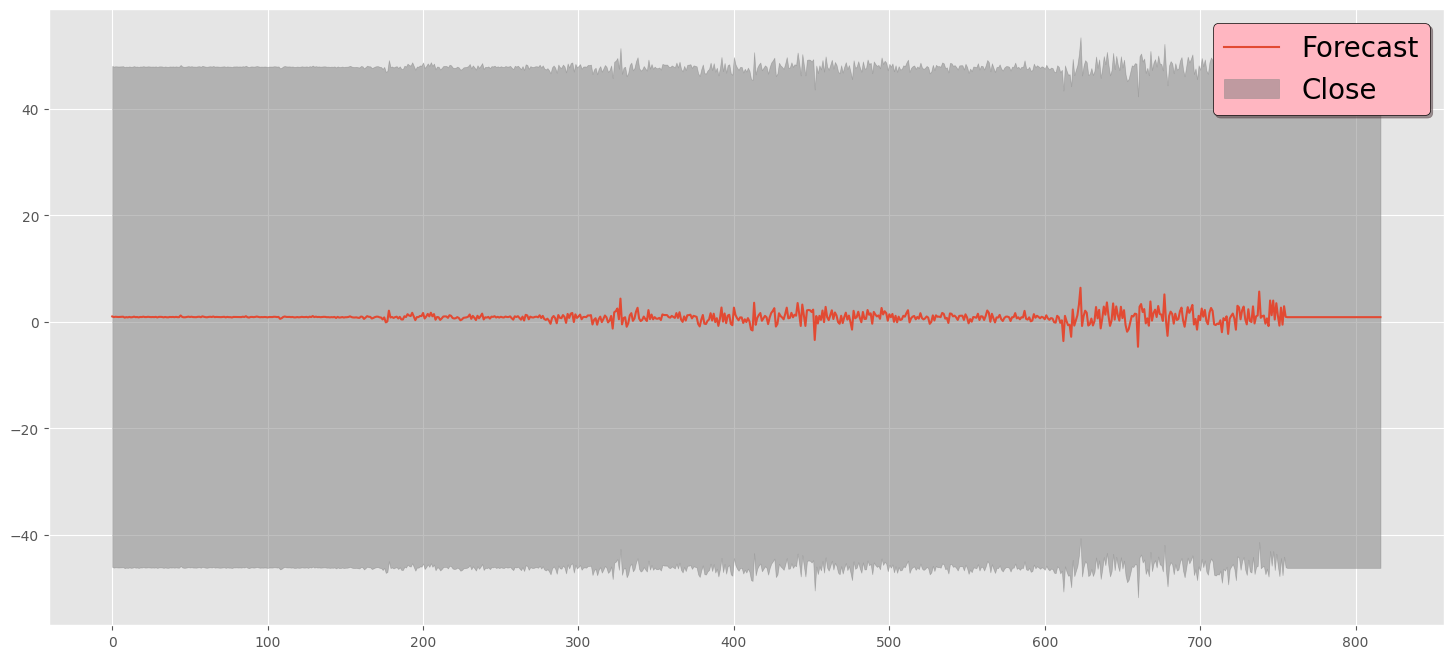

In [79]:
from statsmodels.graphics.tsaplots import plot_predict
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(111)
plot_predict(result=model, start=1, end=len(df_close)+60, ax=ax1)
plt.grid('both')
plt.legend(['Forecast', 'Close', '95% confidence interval'],fontsize = 20, shadow = True, facecolor='lightpink', edgecolor = 'k')
plt.show()

In [80]:
import warnings
warnings.filterwarnings('ignore')


history = [x for x in train_data]

predictions = list()

for t  in range(len(test_data)):
    model = sm.tsa.statespace.SARIMAX(history, order=(0,1,0), seasonal_order=(1,1,1,3))
    model = model.fit()
    fc = model.forecast(alpha = 0.05)
    predictions.append(fc)
    history.append(test_data[t])
print(f"RMSE of SARIMA Model: {np.sqrt(mean_squared_error(test_data,predictions))}")

RMSE of SARIMA Model: 57.86925258260208


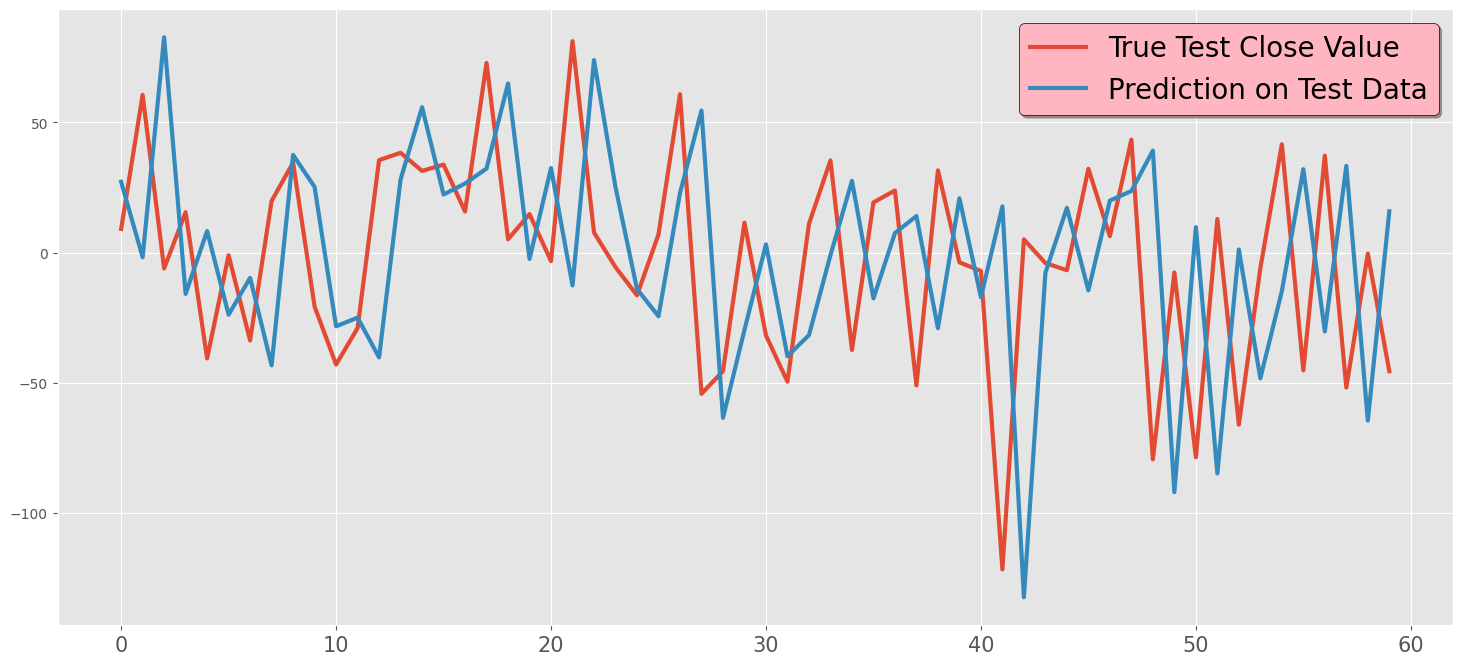

In [81]:
plt.style.use('ggplot')
plt.figure(figsize=(18,8))
plt.grid(True)

plt.plot(range(len(test_data)), test_data, label= 'True Test Close Value', linewidth = 3)
plt.plot(range(len(predictions)), predictions, label= 'Prediction on Test Data', linewidth = 3)


plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.legend(fontsize = 20, shadow = True, facecolor='lightpink', edgecolor = 'k')
plt.show()